# Goal: linking bad actors involved in placement stage
- bad actors in collaboration will have similar paths in a random walk within the graph

# Embedding should only include edges information, but not nodes.csv
- bad actors can play different roles in collaboration (i.e. they will not be similar in transaction data represented by nodes.csv) -> no need to include the features from Task 2 in graph embedding
- if we want to group them together, we should use edges only

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from collections import Counter
from tqdm import tqdm
import copy

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = [20, 5]
plt.rcParams['font.size'] = 12

import networkx as nx
from networkx.exception import NetworkXNoPath
from node2vec import Node2Vec
import os
import re
from datetime import datetime
from gensim.models import Word2Vec

# Read edges file

In [ ]:
edges = pd.read_csv('../UofT_edges.csv')
edges

,source,target,emt
0,983859.0,544485.0,503.807815
1,605618.0,362627.0,5157.568486
2,323189.0,118238.0,498.628481
3,919153.0,983859.0,401.962668
4,995748.0,983859.0,5095.458776
...,...,...,...
466228,743092.0,307628.0,2959.506391
466229,420266.0,489593.0,208.011081
466230,441447.0,877470.0,2221.199295
466231,444883.0,137297.0,1175.932049


## Reweight edges as probability

In [ ]:
# Ensure the sum of weights for all outgoing links from a node is 1
edges_weighted = edges.copy(deep = True)
edges_weighted['source'] = edges_weighted['source'].astype(int).astype(str)
edges_weighted['target'] = edges_weighted['target'].astype(int).astype(str)
edges_weighted['weight'] = edges_weighted['emt'] / edges_weighted.groupby('source')['emt'].transform('sum')
edges_weighted

,source,target,emt,weight
0,983859,544485,503.807815,0.395811
1,605618,362627,5157.568486,0.494825
2,323189,118238,498.628481,0.157296
3,919153,983859,401.962668,0.046041
4,995748,983859,5095.458776,0.219877
...,...,...,...,...
466228,743092,307628,2959.506391,0.919746
466229,420266,489593,208.011081,0.134008
466230,441447,877470,2221.199295,0.923991
466231,444883,137297,1175.932049,0.578436


# Initiate NetworkX graph

In [ ]:
 # created a edgelist and loaded
# https://networkx.org/documentation/stable//reference/generated/networkx.convert_matrix.from_pandas_edgelist.html#networkx.convert_matrix.from_pandas_edgelist
G = nx.from_pandas_edgelist(
    edges_weighted, 
    "source", "target", 
    create_using=nx.DiGraph(), # directed graph with self loops
    edge_attr="weight") # edge weights

## risk ratings

In [ ]:
nodes_df = pd.read_csv('../UofT_nodes.csv')
nodes_df.CUSTOMER_ID = nodes_df.CUSTOMER_ID.astype(int).astype(str)
nodes_in_graph = nodes_df[nodes_df.CUSTOMER_ID.isin(G.nodes)]

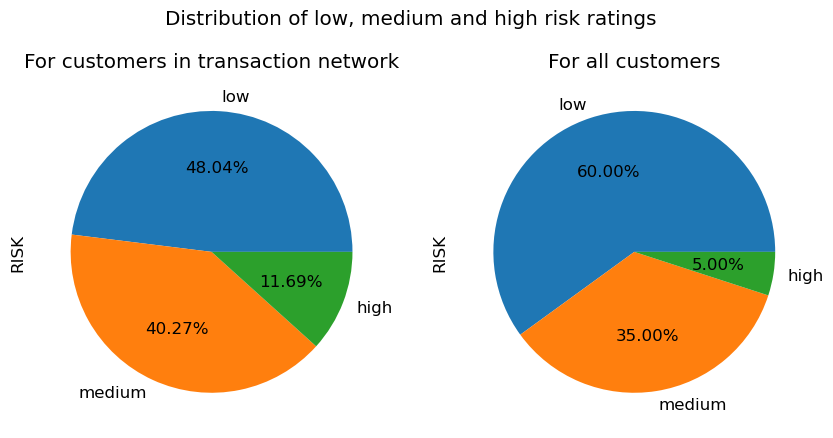

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10, 5))
nodes_in_graph.RISK.value_counts().plot(kind = 'pie', autopct='%.2f%%', ax = axes[0])
axes[0].set_title("For customers in transaction network")
nodes_df.RISK.value_counts().plot(kind = 'pie', autopct='%.2f%%', ax = axes[1])
axes[1].set_title("For all customers")
plt.suptitle("Distribution of low, medium and high risk ratings")
plt.show()

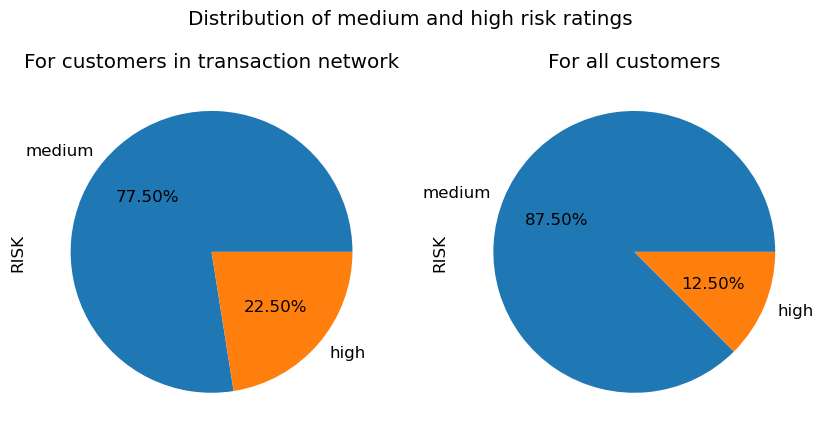

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10, 5))
nodes_in_graph[nodes_in_graph.RISK.isin(['medium', 'high'])].RISK.value_counts().plot(kind = 'pie', autopct='%.2f%%', ax = axes[0])
axes[0].set_title("For customers in transaction network")
nodes_df[nodes_df.RISK.isin(['medium', 'high'])].RISK.value_counts().plot(kind = 'pie', autopct='%.2f%%', ax = axes[1])
axes[1].set_title("For all customers")
plt.suptitle("Distribution of medium and high risk ratings")
plt.show()

## bad actors

In [ ]:
top_50_bad_actors = np.load('../1_FuzzyMatch/top_50_bad_actors_customer_id_high_risk.npy')
top_50_bad_actors

array(['121103', '139717', '853027', '178391', '883073', '251691',
       '376264', '584841', '289684', '618229', '867636', '394833',
       '700653', '764420', '101155', '227988', '437273', '567018',
       '586540', '33253', '913688', '756408', '230856', '175749', '75042',
       '291687', '655172', '549416', '739113', '362267', '68159',
       '266356', '585824', '579603', '402190', '648199', '621895',
       '428035', '123334', '242272', '209016', '123060', '340073',
       '101650', '473144', '468454', '243195', '711146', '817001',
       '171088'], dtype='<U6')

In [ ]:
bad_actors_in_graph = nodes_df[(nodes_df.CUSTOMER_ID.isin(G.nodes)) & (nodes_df.CUSTOMER_ID.isin(top_50_bad_actors))]
bad_actors_in_graph

,BIRTH_DT,CUST_ADD_DT,OCPTN_NM,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,WIRES_CNT_OUT,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,RISK,NAME,GENDER,CUSTOMER_ID
125573,1966-10-20,2004-07-22,89.0,1,1,1.0,38836.477,19.0,19405.0,16.0,11232491.0,251.0,5021706.0,328.0,Low,Low,high,Angela Browning,Female,171088
126872,1955-07-11,2008-10-10,89.0,1,1,1.0,7900.404,4.0,36425.0,28.0,3965227.0,91.0,1402308.0,168.0,Low,Low,high,Alan Milburn,Male,394833
127098,1961-11-12,1999-07-10,89.0,1,1,1.0,25231.011,6.0,18118.0,14.0,4830324.0,19.0,1978448.0,156.0,Low,Low,high,Michael Cullen,Male,340073
127498,1964-06-20,2010-03-06,89.0,1,1,0.0,60148.195,27.0,7926.0,4.0,670645.0,1.0,927467.0,49.0,Low,Low,high,Tetiana Viktorivna Pereverzeva,Female,853027
127950,1960-05-06,1998-05-20,89.0,1,1,1.0,7765.515,1.0,22818.0,19.0,4209995.0,12.0,1503666.0,38.0,Low,Low,high,Elizabeth Smith,Female,289684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983611,1961-10-24,1995-11-26,513.0,1,0,0.0,43813.268,18.0,4993.0,8.0,1471356.0,92.0,612809.0,225.0,High,Low,high,Maria Bono Mack,Female,251691
983626,1960-05-31,1998-05-29,513.0,1,0,0.0,17662.622,11.0,34570.0,37.0,455595.0,78.0,93176.0,43.0,High,Low,high,Alexey Alexeyevich Gromov,Male,139717
985639,1960-06-07,2003-11-27,25.0,1,0,1.0,9.608,0.0,135.0,0.0,1616972.0,25.0,338126.0,9.0,High,Low,high,John Hamilton,Male,75042
989304,1938-03-21,2012-04-29,25.0,0,0,0.0,4246.765,1.0,19203.0,25.0,1913362.0,59.0,137323.0,41.0,High,Low,high,Se Pong Paek,Male,230856


# Domain-independent features
- https://networkx.org/documentation/stable/reference/classes/digraph.html

## !not as important as they are already captured in nodes.csv
- CNT_IN and CNT_OUT measures the degree of each node

## \# of nodes and edges

In [ ]:
type(G)

networkx.classes.digraph.DiGraph

In [ ]:
len(G.nodes)

361178

In [ ]:
len(G.edges)

466233

## degree

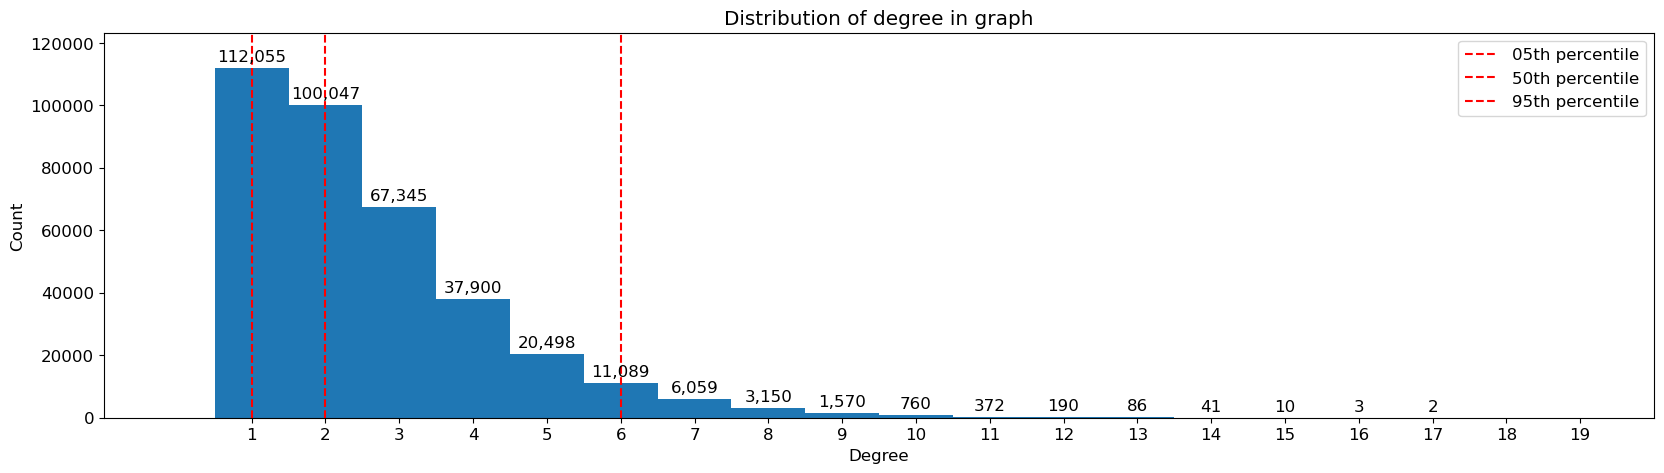

In [ ]:
degrees = [G.degree[node] for node in G.nodes]
fig, ax = plt.subplots(1,1)
plt.hist(degrees, bins = np.arange(1, np.max(degrees), 1), align = 'left')
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Distribution of degree in graph")
for bar in ax.patches:
  if bar.get_height() != 0:
    ax.annotate(format(bar.get_height(), ',.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plt.xticks(ticks=np.arange(1, np.max(degrees) + 1, 1), labels=np.arange(1, np.max(degrees) + 1, 1))
plt.xlim([-1, np.max(degrees) + 1])
plt.ylim(0, np.max([bar.get_height() for bar in ax.patches]) * 1.1)
plt.axvline(np.quantile(degrees, 0.05), label = '05th percentile', color = 'red', ls = '--')
plt.axvline(np.quantile(degrees, 0.50), label = '50th percentile', color = 'red', ls = '--')
plt.axvline(np.quantile(degrees, 0.95), label = '95th percentile', color = 'red', ls = '--')
plt.legend()
plt.show()

### most connected node

In [ ]:
# most connected node
list(G.nodes)[np.array(degrees).argmax()]

'626361'

In [ ]:
G.degree["626361"]

19

In [ ]:
np.array([node for node in nx.all_neighbors(G, "626361")])

array(['319462', '310536', '494909', '23797', '817793', '23905', '804228',
       '418848', '443811', '368375', '466225', '683520', '712895',
       '165000', '642468', '500015', '144170', '828472', '114214'],
      dtype='<U6')

### in-degree and out-degree

In [ ]:
G.in_degree["626361"]

8

In [ ]:
np.array(list(G.predecessors(n="626361")))

array(['319462', '310536', '494909', '23797', '817793', '23905', '804228',
       '418848'], dtype='<U6')

In [ ]:
G.out_degree["626361"]

11

In [ ]:
np.array(list(G.successors(n="626361")))

array(['443811', '368375', '466225', '683520', '712895', '165000',
       '642468', '500015', '144170', '828472', '114214'], dtype='<U6')

### plot subgraph with successors

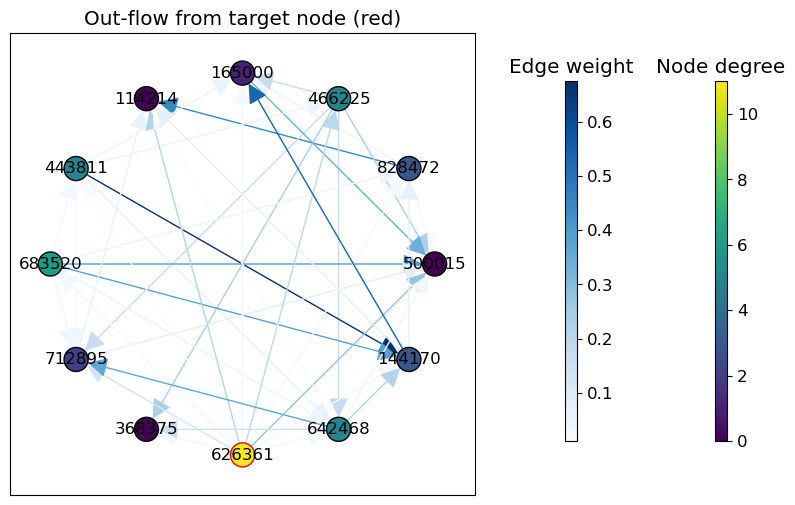

In [ ]:
# target node -> successors 

fig, ax = plt.subplots(1,1, figsize=(6, 6))

target_node = "626361"
subgraph = G.subgraph(nodes=list(G.successors(n=target_node)) + [target_node])
pos = nx.circular_layout(subgraph)
node_colors = [subgraph.out_degree[node] for node in subgraph.nodes]
node_edgecolors = ['r' if node == target_node else "k" for node in subgraph.nodes]
node_cmaps = plt.cm.viridis
edge_colors = [subgraph.get_edge_data(u, v)['weight'] for u, v in subgraph.edges]
edge_cmaps = plt.cm.Blues

nodes = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, cmap=node_cmaps, edgecolors = node_edgecolors, ax=ax)
labels = nx.draw_networkx_labels(subgraph, pos, ax=ax) 
edges = nx.draw_networkx_edges(subgraph, pos, ax=ax,
                               edge_color = edge_colors, 
                               edge_cmap = edge_cmaps,
                              #  edge_vmin = 0,
                              #  edge_vmax = 1,
                               arrowsize = 30,
                               alpha = 1,
                               )
ax.set_title("Out-flow from target node (red)")

pc1 = mpl.collections.PathCollection(edges, cmap=edge_cmaps)
pc1.set_array(edge_colors)
cax = plt.axes([1.05, 0.2, 0.02, 0.6])
plt.colorbar(pc1, cax=cax)
cax.set_title('Edge weight')

pc2 = mpl.collections.PathCollection(nodes, cmap=node_cmaps)
pc2.set_array(node_colors)
cax2 = plt.axes([1.3, 0.2, 0.02, 0.6])
plt.colorbar(pc2, cax=cax2)
cax2.set_title('Node degree')
plt.show()

### plot subgraph with predecessors

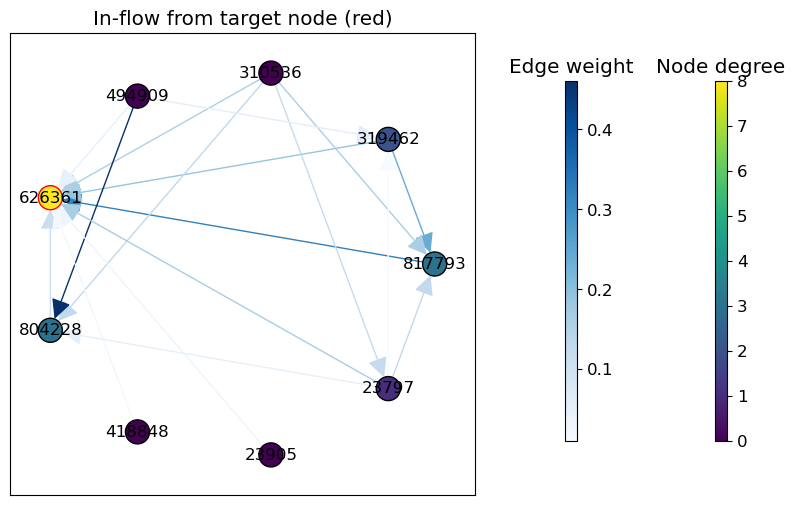

In [ ]:
# target node <- predecessors

fig, ax = plt.subplots(1,1, figsize=(6, 6))

target_node = "626361"
subgraph = G.subgraph(nodes=list(G.predecessors(n=target_node)) + [target_node])
pos = nx.circular_layout(subgraph)
node_colors = [subgraph.in_degree[node] for node in subgraph.nodes]
node_edgecolors = ['r' if node == target_node else "k" for node in subgraph.nodes]
node_cmaps = plt.cm.viridis
edge_colors = [subgraph.get_edge_data(u, v)['weight'] for u, v in subgraph.edges]
edge_cmaps = plt.cm.Blues

nodes = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, cmap=node_cmaps, edgecolors = node_edgecolors, ax=ax)
labels = nx.draw_networkx_labels(subgraph, pos, ax=ax) 
edges = nx.draw_networkx_edges(subgraph, pos, ax=ax,
                               edge_color = edge_colors, 
                               edge_cmap = edge_cmaps,
                              #  edge_vmin = 0,
                              #  edge_vmax = 1,
                               arrowsize = 30,
                               alpha = 1,
                               )
ax.set_title("In-flow from target node (red)")

pc1 = mpl.collections.PathCollection(edges, cmap=edge_cmaps)
pc1.set_array(edge_colors)
cax = plt.axes([1.05, 0.2, 0.02, 0.6])
plt.colorbar(pc1, cax=cax)
cax.set_title('Edge weight')

pc2 = mpl.collections.PathCollection(nodes, cmap=node_cmaps)
pc2.set_array(node_colors)
cax2 = plt.axes([1.3, 0.2, 0.02, 0.6])
plt.colorbar(pc2, cax=cax2)
cax2.set_title('Node degree')
plt.show()

In [ ]:
list(subgraph.edges)[np.argmax(edge_colors)]

('494909', '804228')

## node importance

In [ ]:
result = nx.degree_centrality(G)
sorted_d = sorted(result.items(), key=lambda kv: kv[1],reverse=True)
sorted_d[:5]

[('626361', 5.260578608272398e-05),
 ('404897', 4.706833491612146e-05),
 ('530174', 4.706833491612146e-05),
 ('547346', 4.4299609332820194e-05),
 ('580800', 4.4299609332820194e-05)]

In [ ]:
result = nx.eigenvector_centrality(G)
sorted_d = sorted(result.items(), key=lambda kv: kv[1],reverse=True)
sorted_d[:5]

[('105967', 0.5883461233691999),
 ('914954', 0.43440457180927916),
 ('992722', 0.366175535806972),
 ('255647', 0.27715207609798104),
 ('505490', 0.2434111089123473)]

In [ ]:
result = nx.closeness_centrality(G, distance='weight')
sorted_d = sorted(result.items(), key=lambda kv: kv[1],reverse=True)
sorted_d[:5]

[('624662', 0.0009442335033118034),
 ('996206', 0.0008413683376953677),
 ('876246', 0.0008010419154032603),
 ('826150', 0.0007704550528089325),
 ('324315', 0.0007704177565767086)]

In [ ]:
result = nx.pagerank(G)
sorted_d = sorted(result.items(), key=lambda kv: kv[1],reverse=True)
sorted_d[:5]

[('63726', 2.015390178543311e-05),
 ('689570', 1.9767104467934604e-05),
 ('751187', 1.9691746624357715e-05),
 ('402152', 1.8653171669135774e-05),
 ('558762', 1.8290811328659295e-05)]

## Aggregate measure (max, min, sd, corr)

## Shortest paths

In [ ]:
shortest_path = nx.shortest_path(G)
shortest_paths = [len(shortest_path[source][target]) for source in shortest_path for target in shortest_path[source]]
print(len(shortest_paths))

1002762


In [ ]:
np.unique(shortest_paths, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([361178, 466233, 153593,  14718,   3027,   1818,   1080,    544,
           292,    141,     81,     34,     13,     10], dtype=int64))

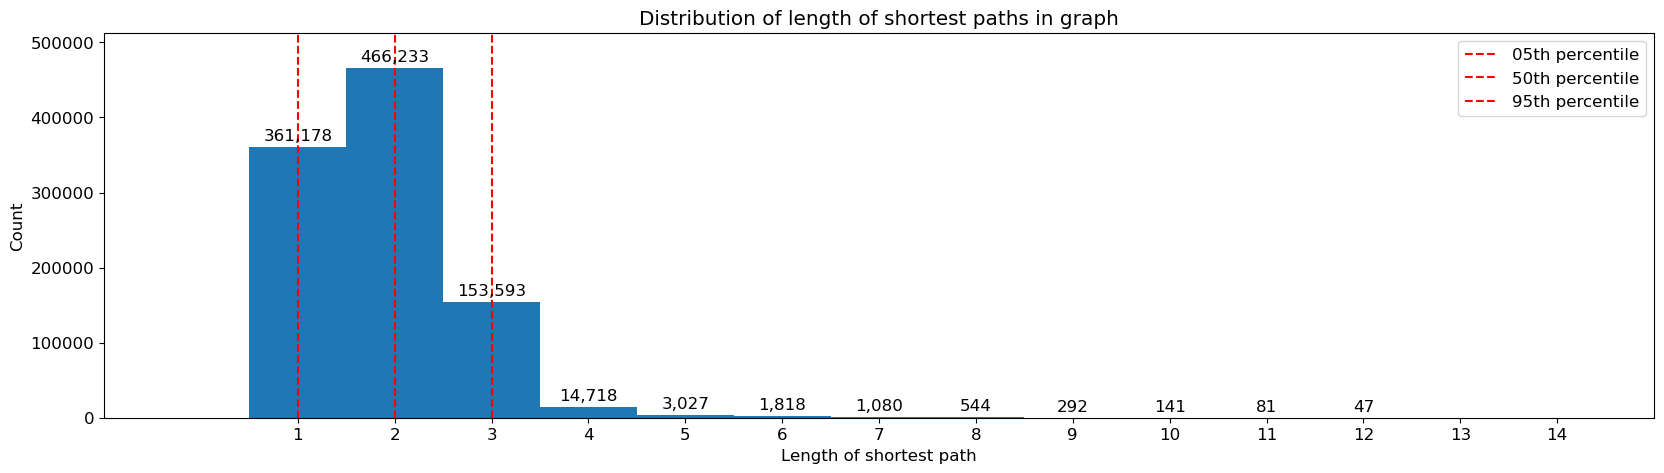

In [ ]:
fig, ax = plt.subplots(1,1)
plt.hist(shortest_paths, bins = np.arange(1, np.max(shortest_paths), 1), align = 'left')
plt.xlabel("Length of shortest path")
plt.ylabel("Count")
plt.title("Distribution of length of shortest paths in graph")
for bar in ax.patches:
  if bar.get_height() != 0:
    ax.annotate(format(bar.get_height(), ',.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plt.xticks(ticks=np.arange(1, np.max(shortest_paths) + 1, 1), labels=np.arange(1, np.max(shortest_paths) + 1, 1))
plt.xlim([-1, np.max(shortest_paths) + 1])
plt.ylim(0, np.max([bar.get_height() for bar in ax.patches]) * 1.1)
plt.axvline(np.quantile(shortest_paths, 0.05), label = '05th percentile', color = 'red', ls = '--')
plt.axvline(np.quantile(shortest_paths, 0.50), label = '50th percentile', color = 'red', ls = '--')
plt.axvline(np.quantile(shortest_paths, 0.95), label = '95th percentile', color = 'red', ls = '--')
plt.legend()
plt.show()

In [ ]:
# shortest_paths = 5 covers 99% of the connections
np.mean([path > 5 for path in shortest_paths])

0.004001946623426097

# Domain-specific features

## shortest path between customer and bad actor
- the longer the path, the more negligible risk it is 

In [ ]:
def from_customer_to_bad_actor(customer, bad_actor):
  try:
    return nx.shortest_path_length(G, source=customer, target=bad_actor, weight='weight') / nx.shortest_path_length(G, source=customer, target=bad_actor, weight=None) # weight by emt
  except NetworkXNoPath:
    return 0

def from_bad_actor_to_customer(customer, bad_actor):
  try:
    return nx.shortest_path_length(G, source=bad_actor, target=customer, weight='weight') # weight by emt
  except NetworkXNoPath:
    return 0

In [ ]:
from_customer_to_bad_actor(customer='494909', bad_actor='804228')

0.4605140746152398

In [ ]:
from_bad_actor_to_customer(customer='494909', bad_actor='804228')

0

## total incoming and outgoing amount
- we already have SUM_IN, SUM_OUT, WIRES_BALANCE, CASH_BALANCE
- if you are trying to detect atypical transfers by a client on an in-and-out basis, or other methods of moving funds quickly, such as a cash deposit followed immediately by a wire transfer of the funds out.

In [ ]:
# incoming amount
np.sum([G.get_edge_data(node, "626361")['weight'] for node in G.predecessors(n="626361")])

1.0474239719041554

In [ ]:
# outgoing amount
np.sum([G.get_edge_data("626361", node)['weight'] for node in G.successors(n="626361")])

1.0

# Graph embedding

## Node2Vec
- (2016, Grover and Leskovec) [node2vec: Scalable Feature Learning for Networks](https://dl.acm.org/doi/pdf/10.1145/2939672.2939754)
- python implementation https://github.com/eliorc/node2vec
- input layer = one-hot of vertices -> hidden layer = embedding -> output layer = skip-gram representation
- probability of random walk
  - edge weight = transition probability
  - Default: If p = q = 1
    - All choices have equal probability = unbiased random walk
  - If p < 1
    - Returning is more likely 
  - If q < 1
    - Forward (depth) is more likely than sideways (breath)
- By simulating a random walk of length $l > k$ we can generate $k$ samples for $l − k$ nodes at once due to the Markovian nature of the random walk
  - $l$ = length per walk
  - $k$ = window size
  - assume $k = 5$ given distribution of shortest paths in the graph, $l = 105$ will give 5 samples for 100 nodes

# Save model

## 10 dimensions for modelling

### unbiased random walk

In [ ]:
random_walks = Node2Vec(G, 
                        dimensions=10,     # performance tends to saturate once the dimensions of the representations reaches around 100
                        walk_length=100,    # Number of nodes in each walk (default: 80)
                        num_walks=15,       # Number of walks per node (default: 10)
                        p = 1,              # p = 1, q = 1 for unbiased random walk
                        q = 1,
                        quiet = False,
                        weight_key = 'weight',
                        workers=1, 
                        )

# Embed nodes
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec 
# window: Maximum distance between the current and predicted word within a sentence.
# min_count: Ignores all words with total frequency lower than this
# batch_words: Target size (in words) for batches of examples passed to worker threads (and thus cython routines).(Larger batches will be passed if individual texts are longer than 10000 words, but the standard cython code truncates to that maximum.)

model = random_walks.fit(window=5, min_count=1, batch_words=4) 

# Save model for later use

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'node2vec_10_{current_time}'
model.save(filename)
print(filename)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 15/15 [01:46<00:00,  7.09s/it]


node2vec_10_20230221_100312


## 2 dimensions for visualization

### unbiased random walk

In [ ]:
random_walks = Node2Vec(G, 
                        dimensions=2,     # performance tends to saturate once the dimensions of the representations reaches around 100
                        walk_length=100,    # Number of nodes in each walk (default: 80)
                        num_walks=15,       # Number of walks per node (default: 10)
                        p = 1,              # p = 1, q = 1 for unbiased random walk
                        q = 1,
                        quiet = False,
                        weight_key = 'weight',
                        workers=1, 
                        )

# Embed nodes
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec 
# window: Maximum distance between the current and predicted word within a sentence.
# min_count: Ignores all words with total frequency lower than this
# batch_words: Target size (in words) for batches of examples passed to worker threads (and thus cython routines).(Larger batches will be passed if individual texts are longer than 10000 words, but the standard cython code truncates to that maximum.)

model = random_walks.fit(window=5, min_count=1, batch_words=4) 

# Save model for later use

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'node2vec_viz_{current_time}'
model.save(filename)
print(filename)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 15/15 [01:45<00:00,  7.05s/it]


node2vec_viz_20230219_204803


### q = 0.5 for homophily

In [ ]:
random_walks_homophily = Node2Vec(G, 
                        dimensions=2,     # performance tends to saturate once the dimensions of the representations reaches around 100
                        walk_length=100,    # Number of nodes in each walk (default: 80)
                        num_walks=15,       # Number of walks per node (default: 10)
                        p = 1,              # p = 1, q = 0.5 for homophily
                        q = 0.5,
                        quiet = False,
                        weight_key = 'weight',
                        workers=1, 
                        )

# Embed nodes
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec 
# window: Maximum distance between the current and predicted word within a sentence.
# min_count: Ignores all words with total frequency lower than this
# batch_words: Target size (in words) for batches of examples passed to worker threads (and thus cython routines).(Larger batches will be passed if individual texts are longer than 10000 words, but the standard cython code truncates to that maximum.)

model = random_walks_homophily.fit(window=5, min_count=1, batch_words=4) 

# Save model for later use

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'node2vec_viz_homophily_{current_time}'
model.save(filename)
print(filename)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 15/15 [01:38<00:00,  6.54s/it]


node2vec_viz_homophily_20230219_210215


### q = 2 for structural similarity

In [ ]:
random_walks_structural_similarity = Node2Vec(G, 
                        dimensions=2,     # performance tends to saturate once the dimensions of the representations reaches around 100
                        walk_length=100,    # Number of nodes in each walk (default: 80)
                        num_walks=15,       # Number of walks per node (default: 10)
                        p = 1,              # p = 1, q = 2 for structural similarity
                        q = 2,
                        quiet = False,
                        weight_key = 'weight',
                        workers=1, 
                        )

# Embed nodes
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec 
# window: Maximum distance between the current and predicted word within a sentence.
# min_count: Ignores all words with total frequency lower than this
# batch_words: Target size (in words) for batches of examples passed to worker threads (and thus cython routines).(Larger batches will be passed if individual texts are longer than 10000 words, but the standard cython code truncates to that maximum.)

model = random_walks_structural_similarity.fit(window=5, min_count=1, batch_words=4) 

# Save model for later use

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'node2vec_viz_structural_similarity_{current_time}'
model.save(filename)
print(filename)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 15/15 [01:45<00:00,  7.01s/it]


node2vec_viz_structural_similarity_20230219_211632


# Load model for visualization

In [ ]:
time_list = []
time_diff = []
# specify regex pattern to load latest model
match_pattern = 'node2vec_viz_([0-9]{8}_[0-9]{6})$'

for current_time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(current_time)

latest = time_list[np.argmin(time_diff)]
# print(latest)
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  # print(file)
  model = Word2Vec.load(file)
  print(file, "loaded")

node_embeddings = pd.concat([
    pd.DataFrame(list(G.nodes), columns=['CUSTOMER_ID']),
    pd.DataFrame(np.vstack([model.wv[node] for node in G.nodes]), columns=[f'embedding_{i}' for i in range(2)])],
    axis=1)

# df_InputData = pd.DataFrame({
#     'source': ['Stephen', "Moron", "Will"],
#     'target': ['Will', "Stephen", "Adam"]
# })

df_InputData = copy.deepcopy(edges_weighted)
df_InputData.source = df_InputData.source.astype(int).astype(str)
df_InputData.target = df_InputData.target.astype(int).astype(str)

Src_Column = 'source'
Tgt_Column = 'target'
arr_SrcTgt= np.array(df_InputData[[Src_Column, Tgt_Column]])

df_Raw_Coords = copy.deepcopy(node_embeddings)
df_Raw_Coords.set_index('CUSTOMER_ID', inplace=True)
df_Raw_Coords.columns = ['X','Y']
df_Raw_Coords['NodeName'] = df_Raw_Coords.index

# Q = nx.Graph()

# Q.add_edges_from(arr_SrcTgt)
# dict_Coords = nx.spring_layout(Q)
# df_Raw_Coords = pd.DataFrame(dict_Coords)
# df_Raw_Coords = df_Raw_Coords.T
# df_Raw_Coords.columns = ['X','Y']
# df_Raw_Coords['NodeName'] = df_Raw_Coords.index

arr_SrcTgt2 = arr_SrcTgt.reshape(1,(len(arr_SrcTgt)*2))
arr_SrcTgt2 = arr_SrcTgt2.reshape(-1)
df_SrcTgt = pd.DataFrame(arr_SrcTgt2,columns=['NodeName'])
arr_Index = []
for i in range(1,(len(arr_SrcTgt)+1)):
        arr_Index.append(i)
        arr_Index.append(i)
df_SrcTgt['c_Index'] = arr_Index
df_SrcTgt

df_InputData.index = df_InputData.index + 1

Merge_1 = pd.merge(
    left=df_SrcTgt,
    right=df_InputData,
    how="inner",
    left_on=df_SrcTgt['c_Index'],
    right_index=True,
)
df_MainDat = pd.DataFrame(Merge_1)
df_MainDat = df_MainDat.drop(columns=['key_0'])
df_MainDat.NodeName = df_MainDat.NodeName.astype(int).astype(str)

Merge_2 = pd.merge(
    left=df_Raw_Coords,
    right=df_MainDat,
    how="left",
    left_on=df_Raw_Coords['NodeName'],
    right_on=df_MainDat['NodeName'],
    suffixes=("", "_y"),
)

df_finaldat = pd.DataFrame(Merge_2)
df_finaldat = df_finaldat.drop(columns=['key_0','NodeName_y'])
df_finaldat['bad_actor'] = df_finaldat.NodeName.isin(np.load('../1_FuzzyMatch/top_50_bad_actors_customer_id_high_risk.npy'))
df_finaldat = df_finaldat.merge(nodes_df[['CUSTOMER_ID', 'NAME', 'RISK']], left_on='NodeName', right_on='CUSTOMER_ID')
df_finaldat

node2vec_viz_20230218_162748 loaded


,X,Y,NodeName,c_Index,source,target,emt,weight,bad_actor,CUSTOMER_ID,NAME,RISK
0,-0.346932,-0.489585,983859,1,983859,544485,503.807815,0.395811,False,983859,Aisha Monarez Cole,high
1,-0.346932,-0.489585,983859,4,919153,983859,401.962668,0.046041,False,983859,Aisha Monarez Cole,high
2,-0.346932,-0.489585,983859,5,995748,983859,5095.458776,0.219877,False,983859,Aisha Monarez Cole,high
3,-0.346932,-0.489585,983859,30,983859,489333,385.979286,0.303240,False,983859,Aisha Monarez Cole,high
4,-0.346932,-0.489585,983859,34,983859,605618,383.063747,0.300949,False,983859,Aisha Monarez Cole,high
...,...,...,...,...,...,...,...,...,...,...,...,...
932461,0.003400,0.222793,553153,466205,553153,263395,108.587644,1.000000,False,553153,"Lightfoot, jo",low
932462,0.008357,0.099154,297191,466212,819669,297191,160.386453,0.589913,False,297191,Ronald Harriman Schwartz,low
932463,0.234186,0.224612,947803,466213,947803,530572,1514.363831,1.000000,False,947803,"Scallon, Sarah Norris",medium
932464,-0.200230,0.006719,218847,466215,450785,218847,149.874181,0.253264,False,218847,Audrey Turnbull Eades,low


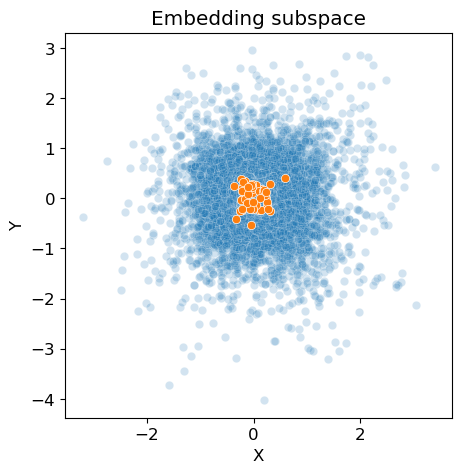

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize = (5,5))
sns.scatterplot(x='X', y='Y', data=df_finaldat[~df_finaldat.bad_actor].drop_duplicates(subset = ['NodeName']), alpha = 0.2, ax = ax)
sns.scatterplot(x='X', y='Y', data=df_finaldat[df_finaldat.bad_actor].drop_duplicates(subset = ['NodeName']), alpha = 1, ax = ax)
plt.title('Embedding subspace')
plt.show()

In [ ]:
df_finaldat[df_finaldat.bad_actor].drop_duplicates(subset = ['NodeName']).sort_values('X')

,X,Y,NodeName,c_Index,source,target,emt,weight,bad_actor,CUSTOMER_ID,NAME,RISK
4280,-0.364005,0.249871,479020,2105,479020,241542,403.091288,0.506714,True,479020,Rakhim Azizboevich Azimov,high
42079,-0.335474,-0.405072,929576,21021,62653,929576,483.903763,0.631688,True,929576,John Williams Bi+t,high
420034,-0.259902,-0.244133,661741,209857,706079,661741,2944.416114,0.802559,True,661741,Christopher Baptiste Cole,high
3399,-0.237465,-0.024350,917730,1669,136166,917730,3925.530764,0.285839,True,917730,Jose Benito Cabrera Cuevas,high
1630,-0.236200,0.382013,376264,771,376264,950557,4097.827835,0.269008,True,376264,"Oleksin, Alexei Ivanovich",high
...,...,...,...,...,...,...,...,...,...,...,...,...
2247,0.252067,-0.132713,288061,1077,288061,393068,419.184978,0.047289,True,288061,"Tsertsel, Ivan Stanislavavich",high
676797,0.277840,-0.213427,849608,338072,849608,855209,199.505285,0.139934,True,849608,David Martinez Vargas,high
3854,0.306518,0.289559,178391,1900,178391,160788,500.427140,0.029500,True,178391,Paul Franklin Watson,high
2407,0.311599,-0.261956,948991,1176,948991,2000,4088.534497,0.319679,True,948991,"El Hassan, Gaffar Mohmed",high


In [ ]:
df_finaldat.sort_values('c_Index').head(50_000).to_csv("tableau_network_test1.csv", index=False)

# Load model

In [ ]:
time_list = []
time_diff = []
# specify regex pattern to load latest model
match_pattern = 'node2vec_([0-9]{8}_[0-9]{6})$'

for time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(time)

latest = time_list[np.argmin(time_diff)]
# print(latest)
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  # print(file)
  model = Word2Vec.load(file)
  print(file, "loaded")

node2vec_20230219_150359 loaded


In [ ]:
model.wv.most_similar('626361')

[('500015', 0.701567530632019),
 ('144170', 0.685906708240509),
 ('715186', 0.6665445566177368),
 ('165000', 0.656952440738678),
 ('683520', 0.6276932954788208),
 ('23573', 0.621967613697052),
 ('712895', 0.6005719900131226),
 ('642468', 0.5373227596282959),
 ('623077', 0.5326859951019287),
 ('23797', 0.4815502464771271)]

In [ ]:
node_embeddings = pd.concat([
    pd.DataFrame(list(G.nodes), columns=['CUSTOMER_ID']),
    pd.DataFrame(np.vstack([model.wv[node] for node in G.nodes]), columns=[f'embedding_{i}' for i in range(100)])],
    axis=1)

node_embeddings

,CUSTOMER_ID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
0,983859,-0.011766,-0.015542,-0.016015,0.001540,-0.000602,0.016258,0.002885,0.012182,0.006377,-0.016109,-0.006282,0.006261,-0.015139,0.004529,-0.004411,-0.025779,-0.002277,0.021818,-0.001257,0.008512,0.017503,-0.011990,0.005888,-0.006561,0.000261,0.008360,-0.011150,-0.009176,-0.007213,0.000555,-0.011860,0.000561,-0.000407,0.002691,0.003818,0.014554,0.026671,0.011661,0.000489,-0.009454,-0.007745,-0.004418,0.001378,0.000417,0.019613,-0.003825,0.000570,0.010365,-0.009657,-0.007378,-0.003258,-0.008387,0.001680,-0.004858,0.005534,0.001874,0.012981,-0.009979,-0.006432,-0.014083,-0.016103,-0.003761,-0.002702,-0.002061,0.005745,0.008190,-0.002949,-0.026426,-0.006632,-0.009270,0.000450,0.016861,-0.004133,0.017705,0.001097,0.008714,-0.005030,-0.026071,0.017430,-0.007954,0.014989,-0.019435,-0.021061,-0.015606,-0.010431,-0.020651,0.008173,0.014837,0.008047,0.018232,0.009334,0.008416,0.010376,-0.004166,-0.001646,-0.002055,-0.008002,-0.005022,0.007279,-0.011513
1,544485,-0.023361,-0.039466,-0.048421,0.004591,-0.002908,0.036093,-0.009657,0.028618,0.002093,-0.047556,-0.006932,0.007094,-0.031328,0.000200,-0.011855,-0.054763,-0.001425,0.042893,-0.004232,0.032393,0.026568,-0.016886,0.010554,-0.021305,-0.005488,0.016702,-0.037135,-0.027049,-0.017243,-0.002522,-0.019327,0.005093,0.011319,0.016953,0.003783,0.048572,0.054146,0.016047,-0.004566,-0.018798,-0.019020,-0.020403,-0.001201,0.006787,0.046939,-0.007194,-0.002943,0.027833,-0.018321,-0.006355,-0.017182,-0.016549,0.000011,-0.017801,0.006888,-0.005203,0.033731,-0.019448,-0.010533,-0.034809,-0.035203,-0.002141,0.000086,0.001872,0.008619,0.016514,-0.007991,-0.060687,-0.008234,-0.015125,-0.008100,0.045288,-0.012430,0.039100,-0.001658,0.015814,-0.005794,-0.061981,0.053990,-0.035018,0.037605,-0.041879,-0.043202,-0.036307,-0.012944,-0.051339,0.018138,0.019990,0.019376,0.045051,0.029170,0.013257,0.034354,-0.010651,-0.010110,-0.009370,-0.016361,-0.017060,0.020589,-0.037292
2,605618,-0.024431,-0.014102,-0.025722,-0.003518,-0.003271,0.014803,0.002151,0.014581,0.008018,-0.024157,-0.007192,0.001281,-0.015475,0.005749,-0.006614,-0.035343,-0.001508,0.027077,-0.004103,0.017810,0.016409,-0.012609,0.015683,-0.018756,-0.009038,0.017737,-0.026593,-0.014616,-0.006031,-0.017100,-0.010706,0.008037,-0.004258,-0.004745,0.015426,0.022255,0.032687,0.019305,-0.001361,-0.006723,-0.003529,-0.008818,-0.004119,0.012478,0.030188,0.007494,-0.008569,0.007762,-0.004072,-0.004266,-0.007098,-0.008366,-0.008130,-0.020317,0.000770,-0.005397,0.027428,-0.017388,-0.002298,-0.013884,-0.014942,-0.008128,0.007633,0.001481,0.006345,0.014060,0.006117,-0.027296,-0.015481,-0.020799,-0.004573,0.028089,-0.003699,0.027326,-0.011516,0.013455,-0.002947,-0.039575,0.034485

## Output embeddings to pkl

In [ ]:
node_embeddings.to_pickle('node_embeddings.pkl')

# Resources for Neo4j
- https://neo4j.com/developer/desktop-csv-import/#loading-data
- https://www.sisu.io/posts/embeddings/
- Neo4j Sandbox
- https://towardsdatascience.com/graph-embeddings-the-summary-cc6075aba007
- https://towardsdatascience.com/graph-embeddings-explained-f0d8d1c49ec
- https://towardsdatascience.com/visualizing-graph-embeddings-with-t-sne-in-python-10227e7876aa
- https://towardsdatascience.com/getting-started-with-graph-embeddings-2f06030e97ae
- https://towardsdatascience.com/create-a-graph-database-in-neo4j-using-python-4172d40f89c4
- https://graphacademy.neo4j.com/courses/modeling-fundamentals/
- https://towardsdatascience.com/understanding-graph-embeddings-with-neo4j-and-emblaze-7e2d6ef56b8c
- https://github.com/Lemon-Soup/NetworkChart
- https://www.youtube.com/watch?v=N7JVM84b8aM&ab_channel=TinyVizTalks